# Detecção de Descrições Litológicas Anômalas em Furos de Sondagem

## Introdução

No dia-a-dia dos galpões de testemunhos, é possível que geólogos cometam erros na descrição dos litotipos ao longo do furo. Nesse sentido, este trabalho visa **desenvolver um modelo não supervisionado para detectar eventuais erros na descrição litológica**, utilizando uma abordagem de **detecção de anomalias**.

## Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings("ignore")

## Importação dos módulos

Neste trabalho, os módulos armazenam as funções auxiliares utilizadas ao longo do fluxo de trabalho e podem ser encontrados na pasta [src](https://github.com/fnaghetini/anomaly-detection-in-drillholes/tree/main/src) do repositório. A separação do código-fonte em módulos visa garantir a legibilidade e facilitar a sua manutenção.

Os módulos presentes nesse repositório são:

- [file_io](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/file_io.py): importação e exportação de arquivos (_file in/out_).
- [stats](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/stats.py): cálculo de estatísticas.
- [plot](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/plot.py): plotagem de gráficos e mapas.
- [pdp_tool](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/stats.py): cálculo do _partial dependent plot_ (esse módulo foi obtido via fork do repositório [pdp-tool](https://github.com/attilalr/pdp-tool)).
- [preprocessing](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/preprocessing.py): procedimentos de pré-processamento.
- [postprocessing](https://github.com/fnaghetini/anomaly-detection-in-drillholes/blob/main/src/postprocessing.py): procedimentos de pós-processamento.

In [2]:
import src.file_io as io
import src.stats as stats
import src.plot as plot
import src.pdp_tool as pdp
import src.preprocessing as pre
import src.postprocessing as post

## Base de dados

A base de dados deste trabalho contempla um subconjunto de furos de sondagem de uma mina real de fosfato. Cada linha representa um intervalo amostral de um determinado furo.

As colunas são representadas por:
- `BHID`: identificador do furo de sondagem
- `FROM`: início do intervalo amostral (em metros)
- `TO`: final do intervalo amostral (em metros)
- `X`: coordenada X do centroide do intervalo amostral (em UTM)
- `Y`: coordenada Y do centroide do intervalo amostral (em UTM)
- `Z`: coordenada Z do centroide do intervalo amostral (em UTM)
- `LITHO`: litotipo presente no intervalo amostral
- Demais colunas: resultados químicos associado ao intervalo amostral (em % e ppm)

In [3]:
dh = io.read_csv('drillholes.csv')

In [4]:
dh.head()

,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,...,NA2O,MNO,CEO2,LA2O3,ND2O3,PR2O3,LOI,RCP,P2O5AP,LITHO
0,DH-0001,0.00,3.40,678.4034,1906.186,410.8728,1.40,0.11,41.3,5.61,...,0.1,0.26,0.42,0.20,0.10,0.04,8.12,0.079,0.081,Solo
1,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,1.41,0.09,42.3,6.22,...,0.1,0.28,0.41,0.20,0.10,0.04,6.78,0.064,0.067,Argilito
2,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,2.17,0.10,41.2,8.36,...,0.1,0.26,0.45,0.22,0.16,0.04,7.13,0.046,0.074,Argilito
3,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,4.77,0.16,41.6,10.10,...,0.1,0.83,0.56,0.29,0.27,0.06,9.52,0.034,0.119,Bebedourito
4,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,3.57,0.17,44.2,10.70,...,0.1,0.55,0.64,0.30,0.25,0.07,9.48,0.048,0.126,Bebedourito


In [5]:
# Agrupamento das colunas
PK = ['BHID', 'FROM', 'TO']
COORDS = ['X', 'Y', 'Z']
ANALYTES = ['P2O5', 'CAO', 'FE2O3', 'SIO2', 'AL2O3', 'MGO', 'TIO2',
            'NB2O5', 'BAO', 'S', 'SRO', 'K2O', 'NA2O', 'MNO', 'CEO2',
            'LA2O3', 'ND2O3', 'PR2O3', 'LOI', 'RCP', 'P2O5AP']

## Limpeza dos dados

In [6]:
print(f"A base de dados apresenta {len(dh)} linhas e {len(dh.columns)} colunas.")

A base de dados apresenta 16890 linhas e 28 colunas.


In [7]:
stats.get_summary_table(dh)

,dType,Valores Faltantes,Valores Preenchidos,Valores Únicos
BHID,object,0,16890,545
FROM,float64,0,16890,3000
TO,float64,0,16890,3187
X,float64,0,16890,9471
Y,float64,0,16890,9367
Z,float64,0,16890,15898
P2O5,float64,83,16807,2207
CAO,float64,83,16807,1313
FE2O3,float64,83,16807,3215
SIO2,float64,83,16807,1676


- Não existem valores faltantes da chave primária (i.e. `BHID`, `FROM` e `TO`)
- Não existem valores faltantes de coordenadas.
- Não existem valores faltantes de `LITHO`.

Como tratamento inicial dos valores faltantes a seguinte premissa foi assumida: caso um intervalo não apresente ao menos um analito com valor válido, ele será removido. Após da etapa de seleção das features, um novo tratamento de valores faltantes será realizado.

In [8]:
dh.dropna(subset=ANALYTES, inplace=True, how='all')
dh.sort_values(by=PK, ignore_index=True, inplace=True)

In [9]:
print(f"A base de dados apresenta {len(dh)} linhas e {len(dh.columns)} colunas.")

A base de dados apresenta 16810 linhas e 28 colunas.


## Análise exploratória dos dados

### Sumário estatístico

A tabela abaixo representa o sumário estatístico geral das features (i.e. analitos).

In [10]:
stats.calculate_stats_table(dh[ANALYTES])

,X̅,50%,Min,10%,99.5%,Max,Amp,S²,S,Cᵥ,Skew
P2O5,8.253648,5.670,0.020,1.840,33.60000,37.200,37.180,51.864419,7.201696,0.872547,1.535635
CAO,12.948414,12.300,0.010,0.280,49.29700,53.100,53.090,162.473763,12.746520,0.984408,0.728803
FE2O3,26.233574,21.700,0.740,9.496,75.00000,88.180,87.440,256.276006,16.008623,0.610234,0.837044
SIO2,19.725144,19.400,0.120,2.850,68.59100,94.300,94.180,179.409684,13.394390,0.679052,0.732166
AL2O3,8.366020,4.070,0.010,0.940,34.50000,40.200,40.190,89.955160,9.484469,1.133690,1.474657
MGO,3.847860,1.250,0.010,0.160,18.70000,27.300,27.290,23.775768,4.876040,1.267208,1.323951
TIO2,7.106092,5.950,0.010,1.310,26.20000,40.200,40.190,27.920946,5.284027,0.743591,1.287831
NB2O5,0.238103,0.160,0.000,0.060,1.72290,4.440,4.440,0.068635,0.261983,1.100292,4.307357
BAO,0.434634,0.250,0.010,0.080,3.30940,7.040,7.030,0.289595,0.538140,1.238146,3.482956
S,0.043708,0.010,0.010,0.010,1.14625,4.420,4.410,0.026944,0.164146,3.755515,9.757444


### Frequência absoluta dos litotipos

O gráfico abaixo mostra a distribuição de frequências dos litotipos (i.e. variável `LITHO`).

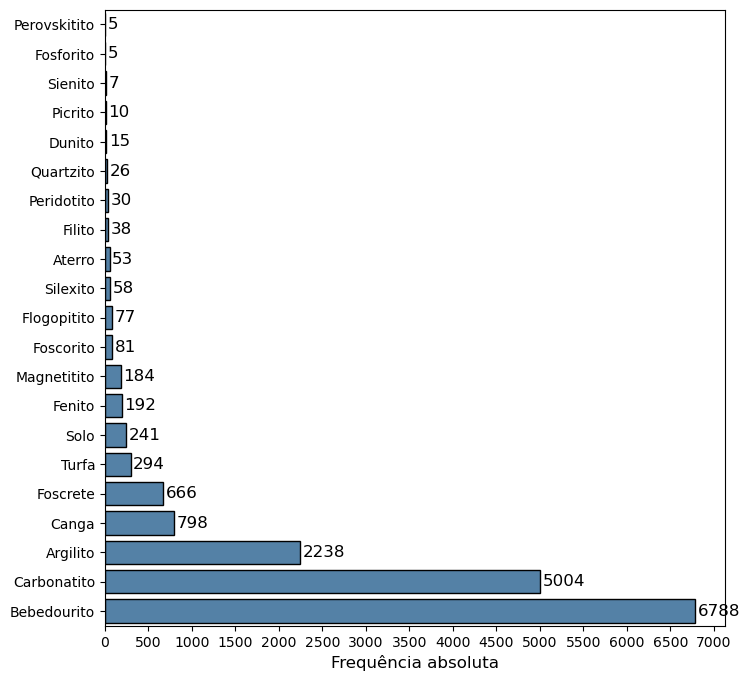

In [11]:
plot.plot_category_frequencies(dh, 'LITHO')

- Os três litotipos mais frequentes (i.e. `Bebedourito`, `Carbonatito` e `Argilito`) correspondem a > 80 % dos dados.
- Portanto, nota-se um desbalanceamento de classes acentuado.
- Para fins de simplificação, apenas intervalos de sondagem com as cinco litologias mais frequentes serão avaliados neste trabalho.

**Nota:** utilizou-se o termo "desbalanceamento de classes" apenas para ilustrar que a variável `LITHO` apresenta uma distribuição desigual de suas categorias. Entretanto, enfatiza-se que a tarefa deste trabalho é do tipo **detecção de anomalias não supervisionada**, em que `LITHO` será tratada como uma feature.

In [12]:
# Seleção dos intervalos com as litologias mais frequentes
dh = dh[dh['LITHO'].isin(('Bebedourito', 'Carbonatito', 'Argilito', 'Canga', 'Foscrete'))]
dh.reset_index(drop=True, inplace=True)

### Distribuição dos analitos por litotipo

O gráfico abaixo mostra a distribuição dos analitos agrupados pelos litotipos.

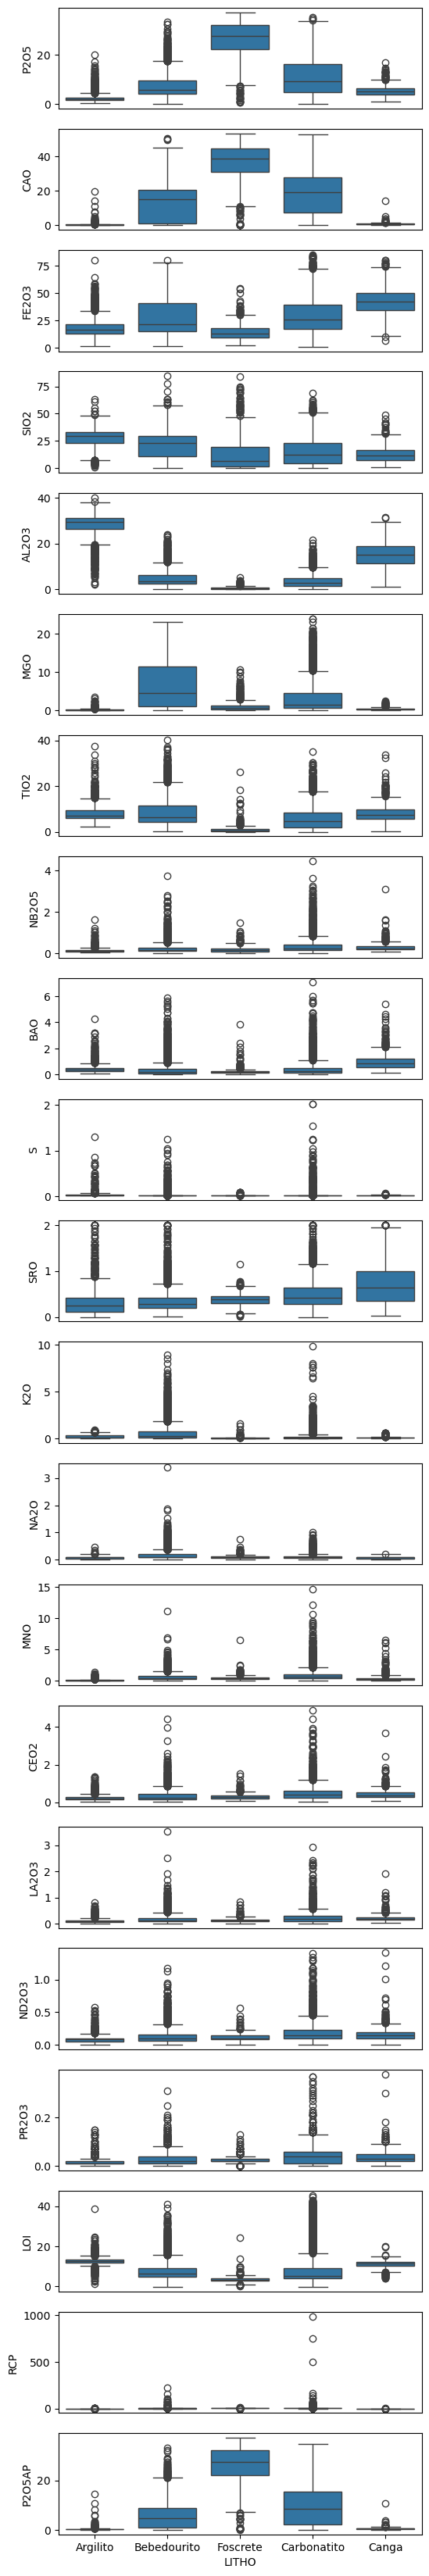

In [13]:
plot.plot_boxplots_by_litho(dh, ANALYTES, 'LITHO')

- Os elementos maiores, sob a forma de óxidos (i.e. `P2O5`, `CAO`, `FE2O3`, `SIO2`, `AL2O3`, `MGO`) apresentam uma variabilidade significativa quando agrupados pelos litotipos.
- Os analitos `NB2O5`, `BAO`, `S`, `K2O`, `NA2O`, `MNO` e `LOI`, por outro lado, apresentam uma baixa variabilidade quando agrupadas pelos litotipos.
- Os elementos terras raras (i.e. `CEO2`, `LA2O3`, `ND2O3`, `PR2O3`) também apresentam uma baixa variabilidade quando agrupadas pelos litotipos.
- O analito `RCP` apresenta baixíssima variabilidade quando agrupado pelos litotipos. Entretanto, aparenta apresentar alguns valores extremos (i.e. RCP > 500) para o litotipo `Carbonatito`.

### Correlação linear entre analitos

A análise da correlação entre as variáveis no espaço das features é importante para detectar a existência de features redundantes. Uma maneira se fazer isso é a partir da estatística bivariada coeficiente de correlação linear (i.e. Coeficiente de Pearson). A figura abaixo apresenta os coeficientes de correlação linear entre os analitos..

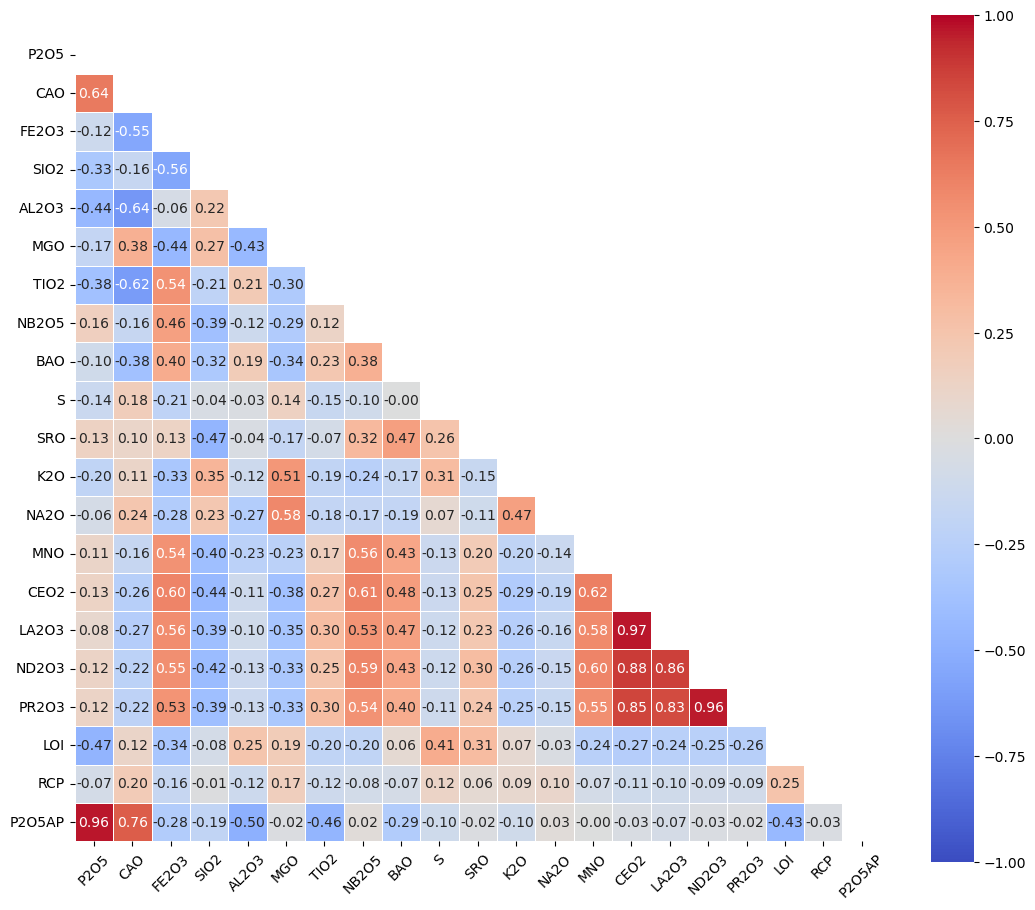

In [14]:
plot.plot_correlation_heatmap(dh, ANALYTES)

A figura abaixo mostra apenas valores de Coeficiente de Person maiores ou iguais ao módulo de 0.7 para facilitar a visualização dos analitos com forte correlação linear (positiva e negativa).

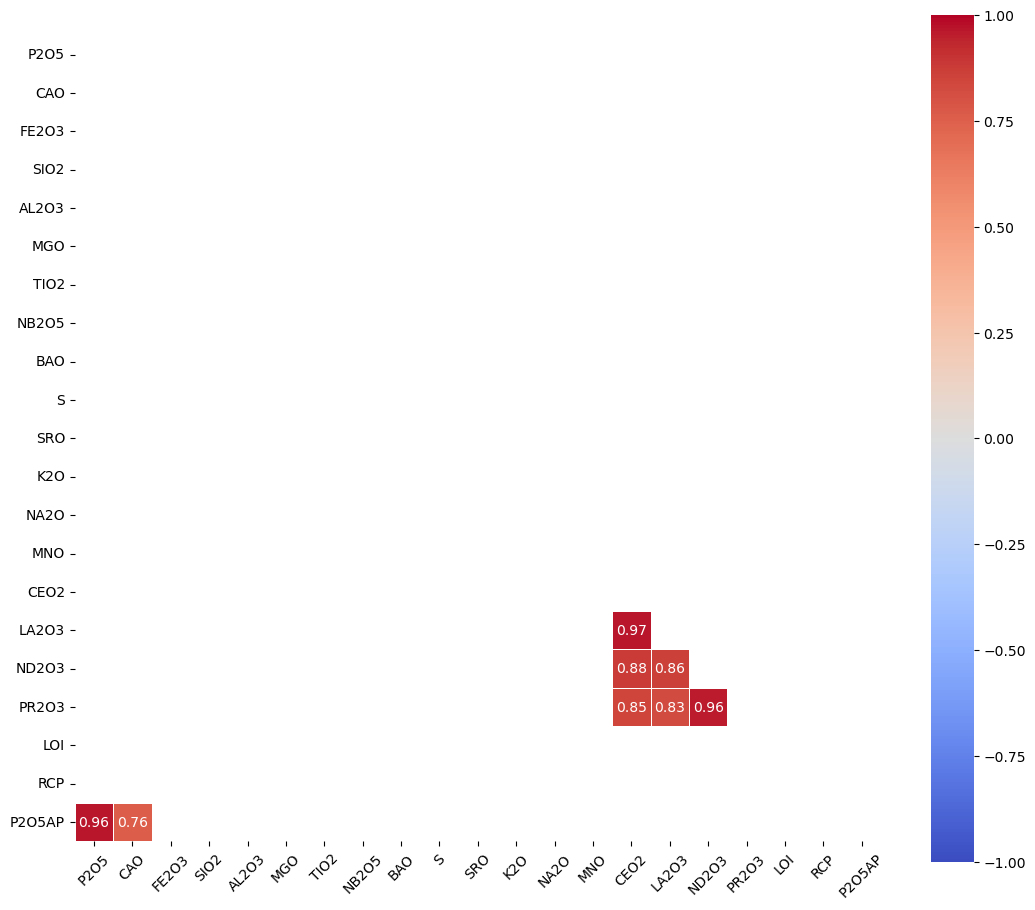

In [15]:
plot.plot_correlation_heatmap(dh, ANALYTES, corr_filter=0.7)

- Os analitos associados a elementos terras raras (i.e. `CEO2`, `LA2O3`, `ND2O3`, `PR2O3`) apresentam forte correlação linear positiva entre si.
- Os analitos `P2O5` e `CAO` apresentam forte corelação linear positiva com o analito `P2O5AP`. Isso já era esperado, já que `P2O5AP` (i.e. P2O5 apatítico) é uma variável calculada a partir das variáveis `P2O5` e `CAO`.

### Seleção das features

Nesta etapa, serão selecionadas as features que serão utilizadas no modelo. Para a seleção dessas variáveis explicativas, as seguintes premissas foram seguidas:
- Os analitos associados a elementos terras raras (i.e. `CEO2`, `LA2O3`, `ND2O3`, `PR2O3`) serão excluídos, pois apresentam baixa variabilidade quando agrupados pelos litotipos e por exibirem alta correlação linear positiva entre si.
- Os analitos `NB2O5`, `BAO`, `S`, `K2O`, `NA2O`, `MNO`, `LOI`, `SRO` e `RCP` serão excluídos também por apresentam uma baixa variabilidade quando agrupados pelos litotipos.
- O analito `P2O5AP` será excluído por apresentar forte correlação linear positiva com os analitos `CAO` e `P2O5`.
- Portanto, os analitos `P2O5`, `CAO`, `FE2O3`, `SIO2`, `AL2O3` e `MGO` foram as **features selecionadas** (juntamente com a feature categórica `LITHO`) para treinar o modelo posteriormente.

**Nota:** após a seleção das features, qualquer registro que não apresentar valores válidos (i.e. diferente de NaN) para todas as features será removido da base de dados.

In [16]:
CONTINUOUS_FEATURES = ['P2O5', 'CAO', 'FE2O3', 'SIO2', 'AL2O3', 'MGO']
dh = dh.copy()[PK + COORDS + CONTINUOUS_FEATURES + ['LITHO']]
dh.dropna(subset=CONTINUOUS_FEATURES, inplace=True, how='all')
dh.sort_values(by=PK, ignore_index=True, inplace=True)
dh.head()

,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITHO
0,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,1.41,0.09,42.3,6.22,14.3,0.58,Argilito
1,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,2.17,0.10,41.2,8.36,13.1,0.43,Argilito
2,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,4.77,0.16,41.6,10.10,13.5,0.13,Bebedourito
3,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,3.57,0.17,44.2,10.70,12.0,0.14,Bebedourito
4,DH-0001,15.00,18.00,677.6160,1906.664,396.1015,2.97,0.16,42.1,12.30,12.9,0.12,Bebedourito


### Partial dependent plot

O Partial Dependent Plot (PDP) é uma ferramenta de análise exploratória bastante útil para verificar a presença de correlação (não necessariamente linear) entre variáveis contínuas e categóricas.

Neste trabalho, o PDP será utilizado para verificar a correlação entre os analitos (variáveis contínuas) e os litotipos (variável categórica).

Como primeiro passo, serão criadas variáveis _dummy_ para codificar as cinco litologias presentes na base de dados.

In [17]:
pre.create_dummy_variables_from_categ_feature(dh, 'LITHO')
dh.head()

,BHID,FROM,TO,X,Y,Z,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITHO,IS_ARG,IS_BEB,IS_FOS,IS_CAR,IS_CAN
0,DH-0001,3.40,5.00,678.2769,1906.266,408.3772,1.41,0.09,42.3,6.22,14.3,0.58,Argilito,1,0,0,0,0
1,DH-0001,5.00,8.65,678.1301,1906.344,405.7575,2.17,0.10,41.2,8.36,13.1,0.43,Argilito,1,0,0,0,0
2,DH-0001,8.65,12.00,677.9395,1906.447,402.2642,4.77,0.16,41.6,10.10,13.5,0.13,Bebedourito,0,1,0,0,0
3,DH-0001,12.00,15.00,677.7742,1906.552,399.0953,3.57,0.17,44.2,10.70,12.0,0.14,Bebedourito,0,1,0,0,0
4,DH-0001,15.00,18.00,677.6160,1906.664,396.1015,2.97,0.16,42.1,12.30,12.9,0.12,Bebedourito,0,1,0,0,0


Para fins de simplificação do trabalho, serão calculados PDP's apenas para as três litologias mais frequentes (i.e. `Bebedourito`, `Carbonatito` e `Argilito`):

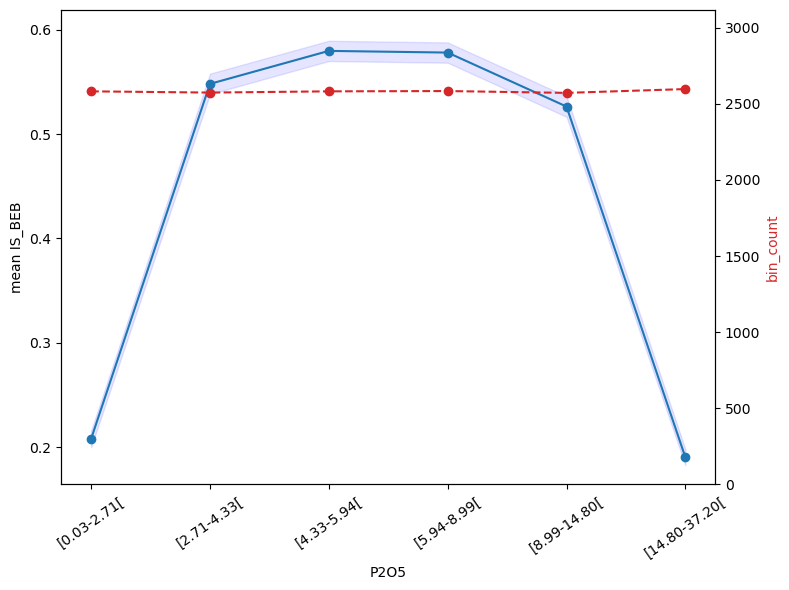

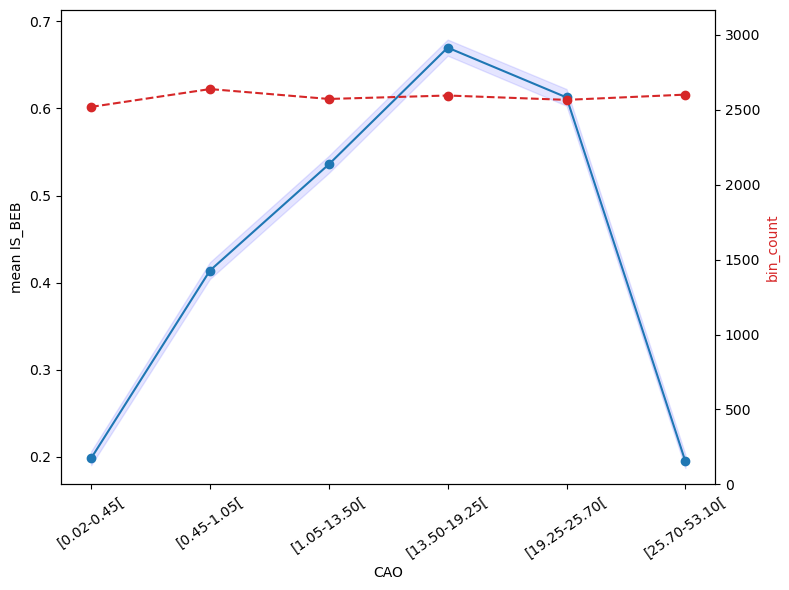

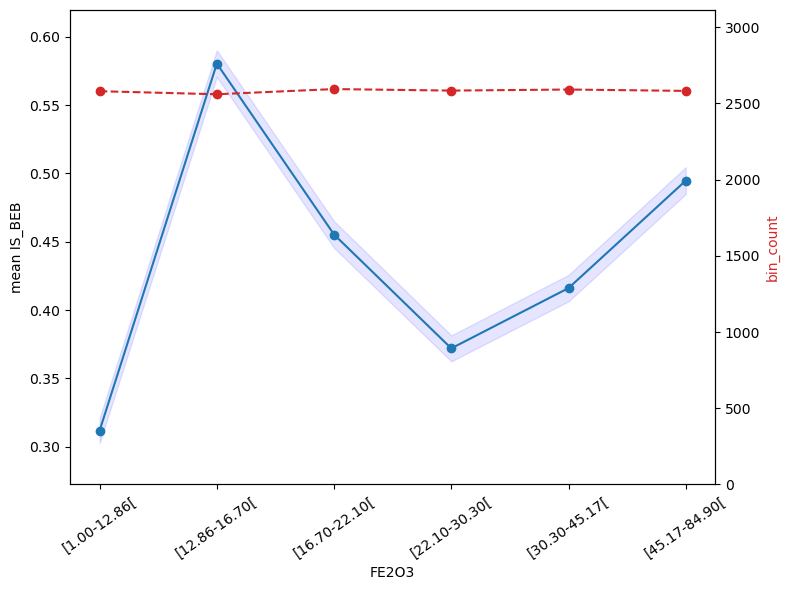

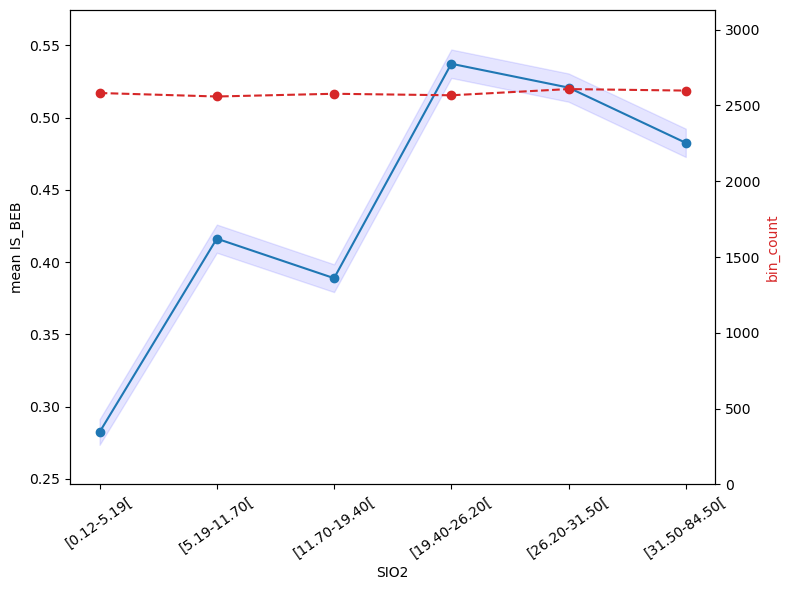

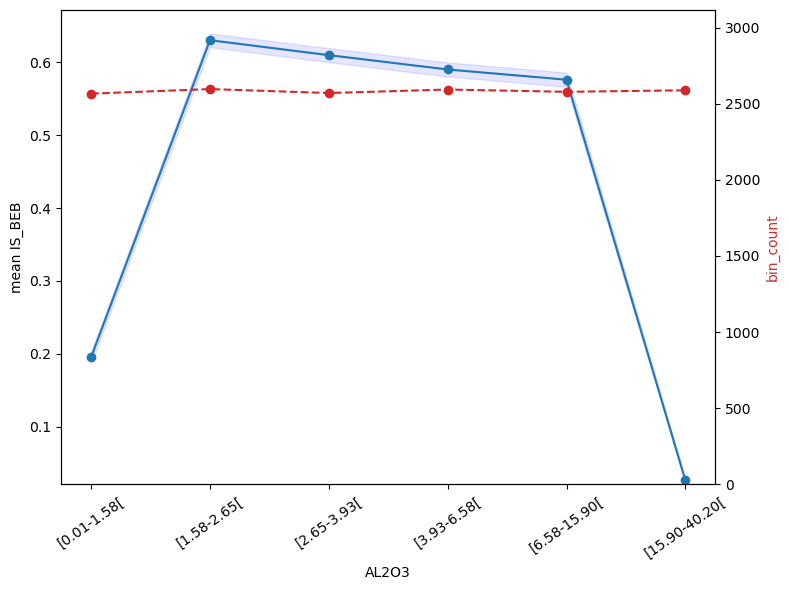

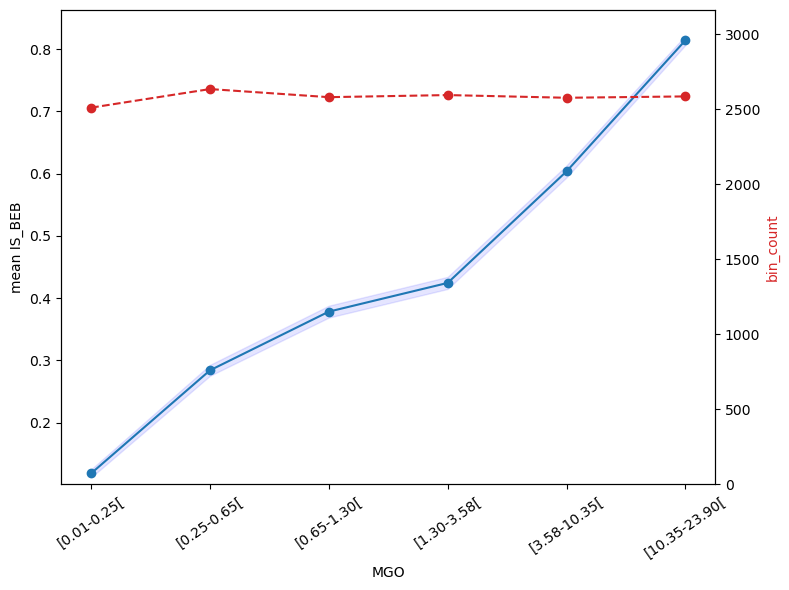

In [18]:
# PDP (Bebedourito)
pdp.pdp(dh, CONTINUOUS_FEATURES, 'IS_BEB', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `CAO`. Isso já era esperado, pois o bebedourito é uma rocha ígnea cumulática constituída por minerais ricos em Ca (eg. diopsídio, perovskita, titanita).
- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `SIO2`. O aumento dos teores de sílica pode ser justificado tanto por uma contaminação crustal, quanto pela transformação da perovskita em titanita, durante a série de evolução magmática.
- A frequência média de `Bebedourito` tende a aumentar com o aumento dos teores de `MGO`. Isso pode ser justificado pelo fato de o bebedourito ser uma rocha rica em minerais máficos (i.e. ricos em magnésio), como diopsídio, flogopita e, secundariamente, olivina.

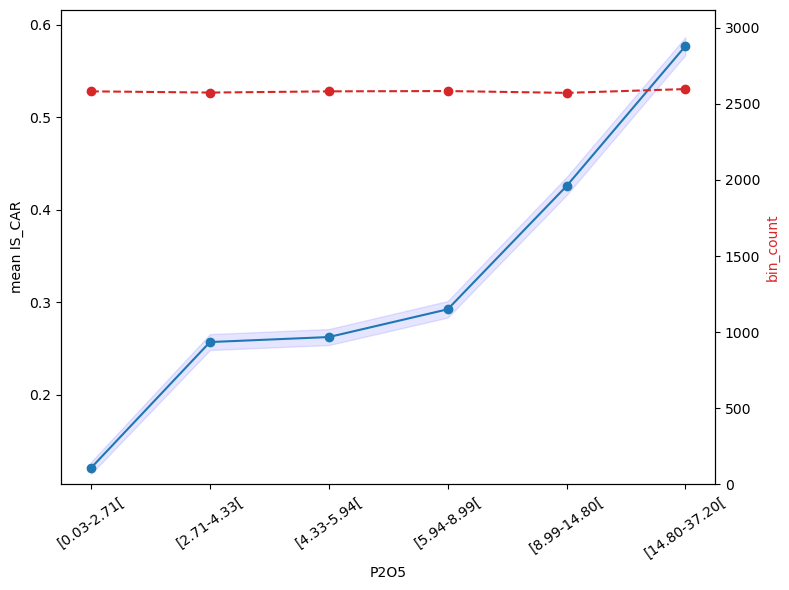

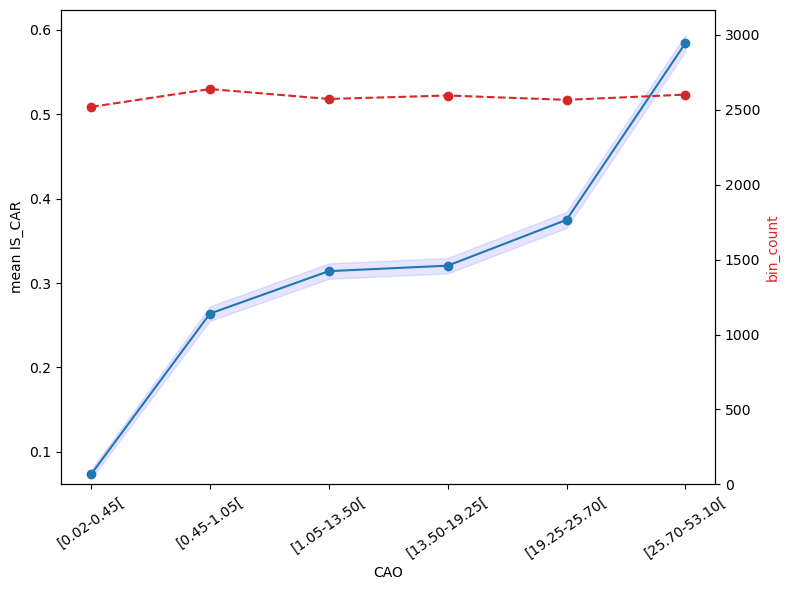

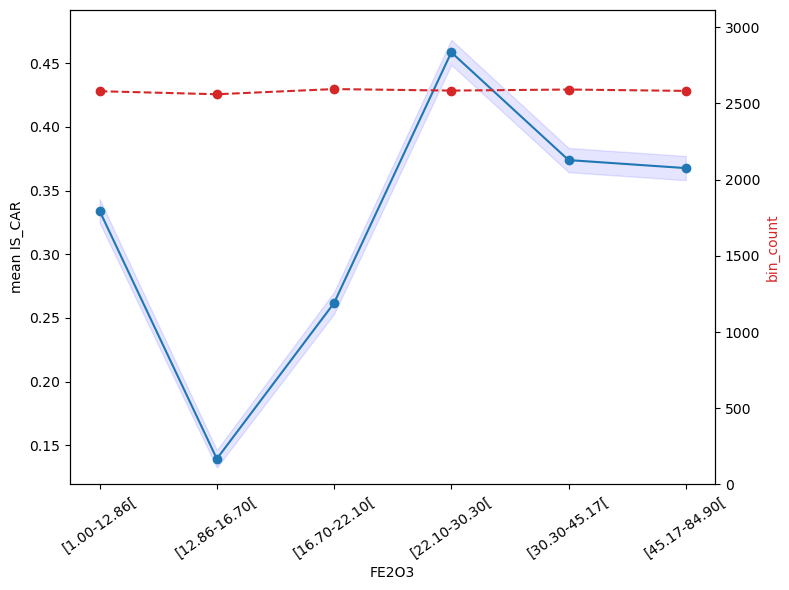

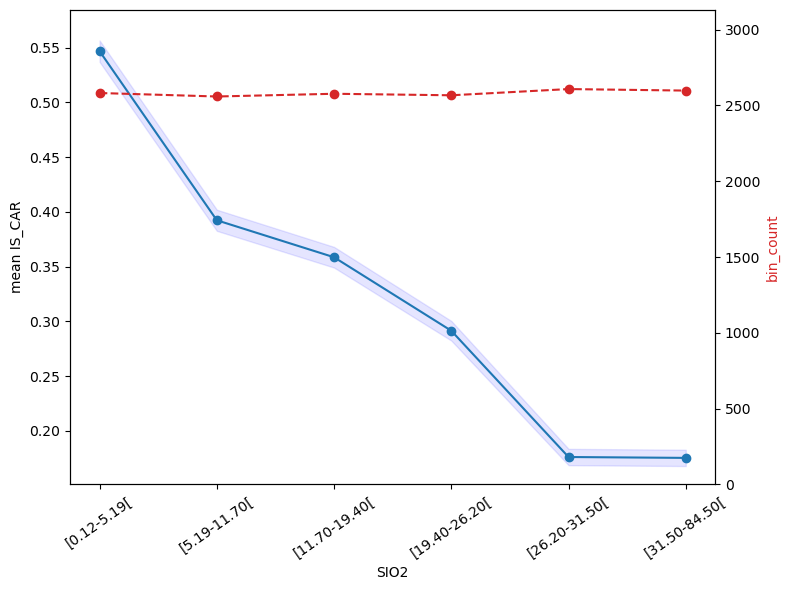

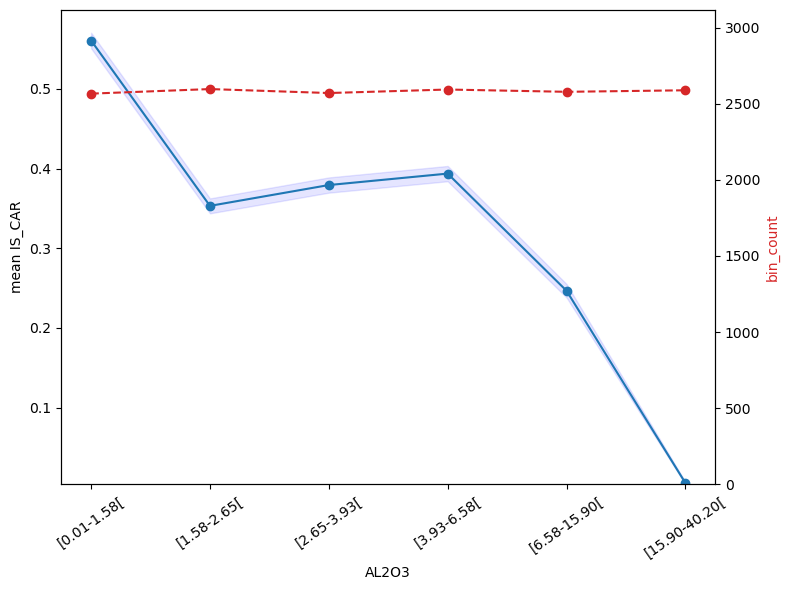

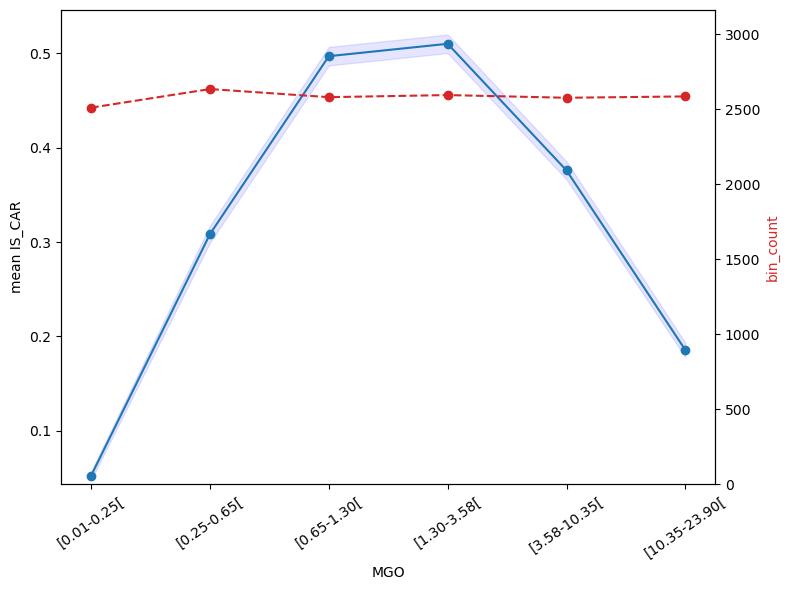

In [19]:
# PDP (Carbonatito)
pdp.pdp(dh, CONTINUOUS_FEATURES, 'IS_CAR', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Carbonatito` tende a aumentar com o aumento dos teores de `P2O5` e `CAO`. Isso já era esperado, pois o carbonatito é uma rocha ígnea constituída por carbonatos (ricos em cálcio) e e apatita (principal fosfato de cálcio e mineral-minério).
- A frequência média de `Carbonatito` tende a diminuir com o aumento dos teores de `SIO2`. Esse comportamento era esperado, pois carbonatitos são rochas tipicamente pobres em sílica.
- A frequência média de `Carbonatito` tende a diminuir com o aumento dos teores de `AL2O3`. Esse comportamento era esperado, pois carbonatitos são rochas tipicamente pobres em alumínio.

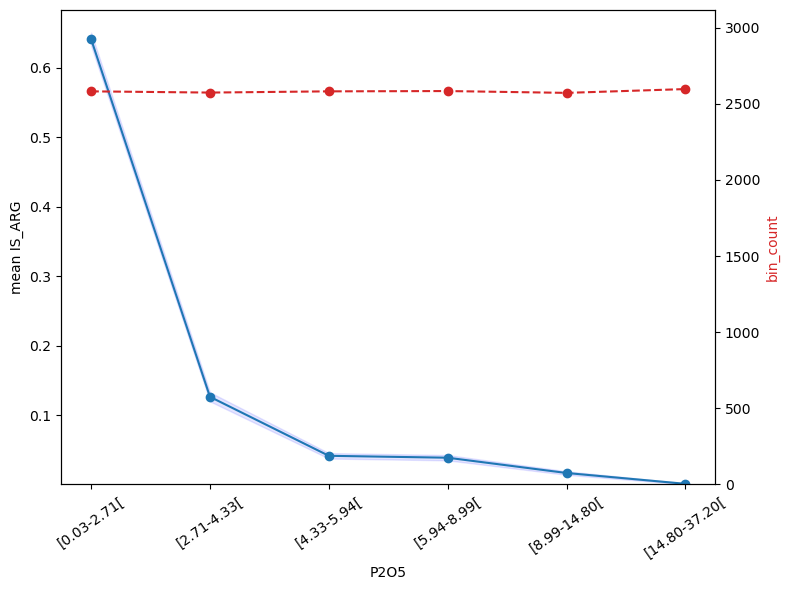

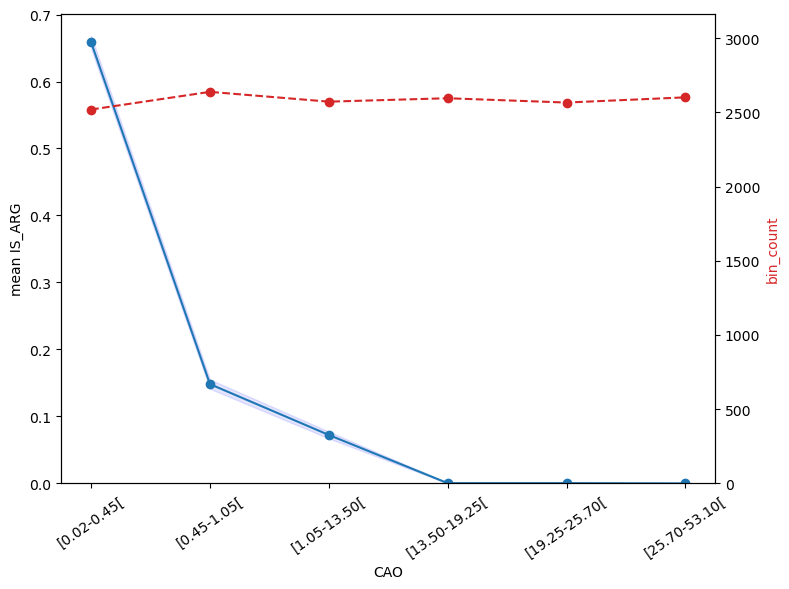

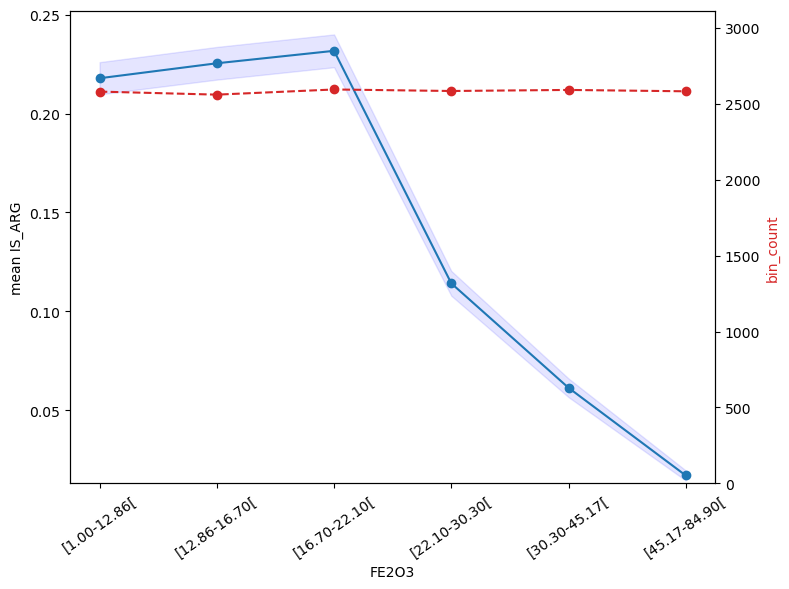

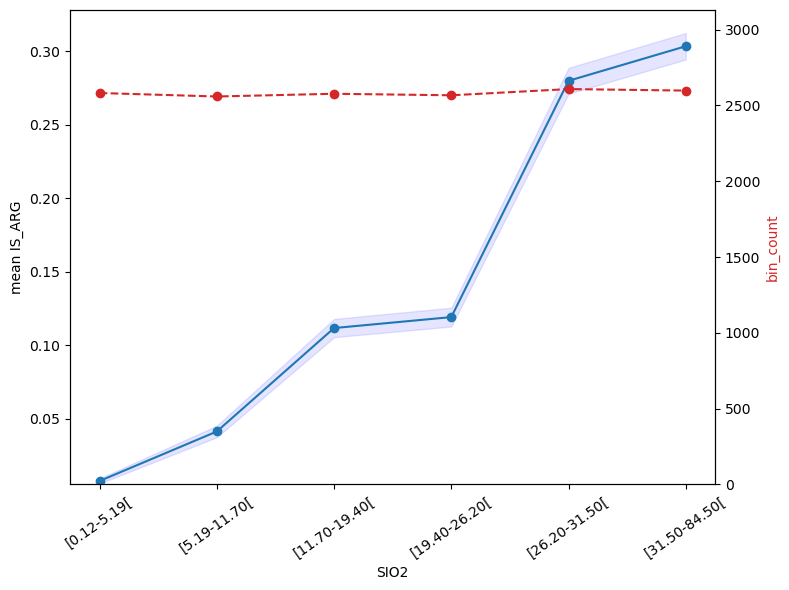

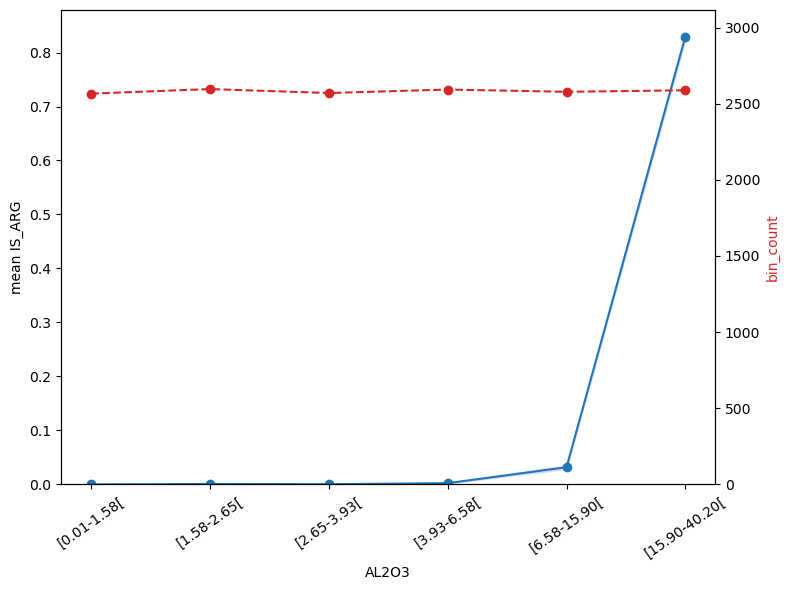

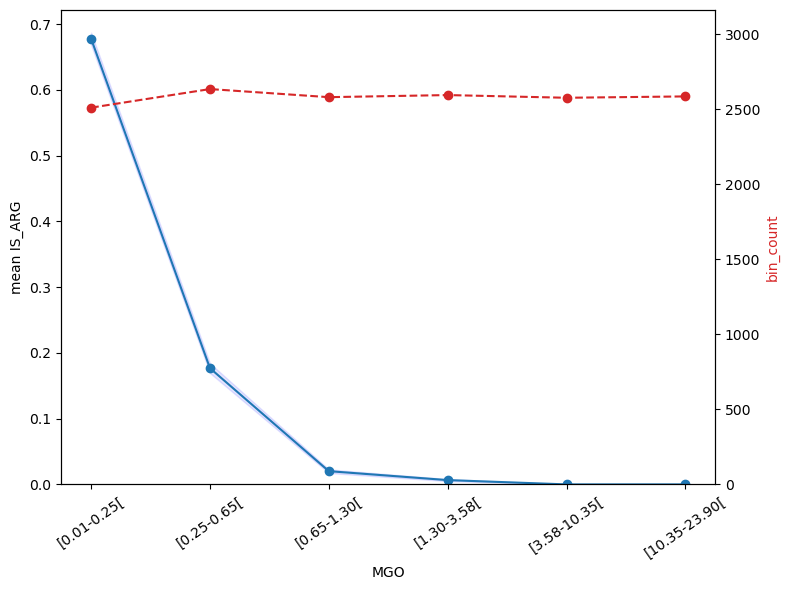

In [20]:
# PDP (Argilito)
pdp.pdp(dh, CONTINUOUS_FEATURES, 'IS_ARG', n=6, writefolder=None, digits=2, figsize=(8,6))

- A frequência média de `Argilito` tende a diminuir com o aumento dos teores de `P2O5`, `CAO` e `MGO`. Isso já era esperado, pois o argilito é uma rocha sedimentar de granulometria argila tipicamente formada a partir do intemperismo de rochas pré-existentes. Nesse sentido, durante o intemperismo químico, elementos mais móveis (eg. P, Ca e Mg) tendem a ser lixiviados.
- A frequência média de `Argilito` tende a aumentar com o aumento dos teores de `SIO2` e `AL2O3`. Isso já era esperado, pois, durante o intemperismo químico, elementos mais imóveis (eg. Si e Al) tendem a se concentrar na rocha sedimentar.

### Análise de Componentes Principais

A Análise de Componentes Principais (ACP) consiste em um algoritmo que objetiva encontrar projeções similares às instâncias originais, mas que apresentam uma dimensionalidade significativamente menor. A partir da ACP, são calculadas as componentes principais, ou seja, vetores ortogonais entre si no espaço de atributos (i.e. feature space) que definem um novo sistema de coordenadas em que os dados originais serão projetados.

**Nota:** neste trabalho, a ACP será realizada para fins exploratórios e não para fins de pré-processamento.

In [21]:
# Cálculo das componentes principais
pca = PCA(n_components = 6)
pca.fit(dh[CONTINUOUS_FEATURES].values)
principal_components = pca.transform(dh[CONTINUOUS_FEATURES].values)

A figura a seguir mostra um gráfico da variância explicada relativa por cada uma das seis componentes principais.

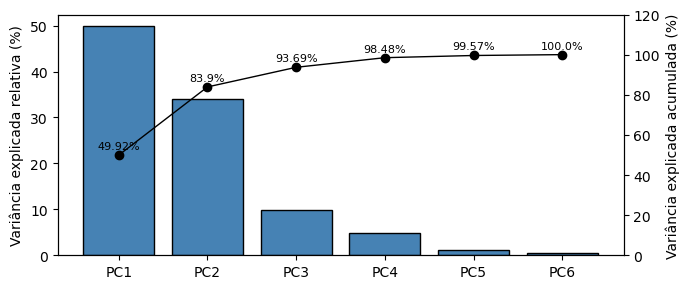

In [22]:
plot.plot_explained_variance_for_pcs(pca)

- As duas primeiras componentes principais (i.e. `PC1` e `PC2`) "explicam" > 80% da variância presente nas seis features iniciais.

A figura abaixo apresenta um scatter plot entre as duas primeiras componentes principais colorido pela variável categórica `LITHO`:

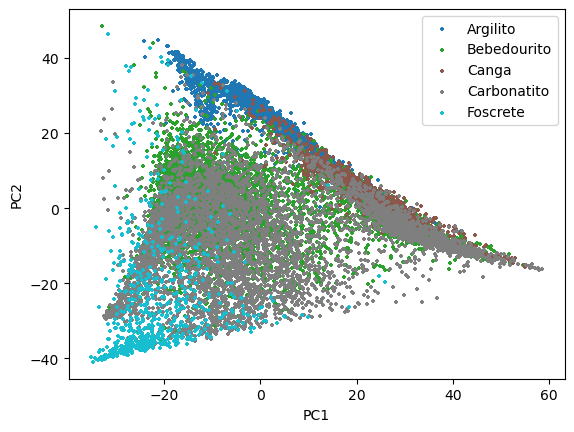

In [23]:
plot.plot_pcs_colored_by_litho(principal_components, dh['LITHO'].values)

- De modo geral, as litologias mostram um certo grau de separação entre si, quando plotadas sobre as duas primeiras componentes principais.
- A litologia `Argilito` é mais frequente para valores de `PC2` superiores a 20.
- A litologia `Bebedourito` é mais frequente para valores de `PC2` superiores -20.
- A litologia `Canga` é mais frequente para valores de `PC2` superiores 0.
- A litologia `Carbonatito` ocorre de forma espalhada ao longo do espaço das componentes `PC1` e `PC2`.
- A litologia `Foscrete` é mais frequente para valores de `PC1` inferiores a 0.

## Pré-processamento

As etapas de pré-processamento dos dados são:

1. Codificação binária da variável `LITHO` (i.e. _One Hot Encoding_).
2. Estandardização das variáveis.

Neste trabalho, como o objetivo é encontrar possíveis descrições litológicas anômalas, a variável `LITHO` é tratada como feature. Caso ela não fosse considerada como feature, o modelo resultante treinado apenas com os analitos poderia ser útil para detectar eventuais erros analíticos, mas não erros associados à descrição litológica dos furos. Como `LITHO` é uma variável categórica, ela será codificada em colunas $k$ variáveis _dummy_, sendo $k$ o número de litotipos.

Em seguida, as features contínuas (i.e. analitos) serão estandardizadas. Esta é uma boa prática, já que alguns modelos podem sofrer com viéses associados à magnitude das features (no caso deste trabalho, principalmente os modelos DBSCAN e Local Outlier Factor).

Definidas as etapas de pré-processamento, em pipeline de pré-processamento pode ser instanciado:

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(), ['LITHO']),
        ('continuous', StandardScaler(), CONTINUOUS_FEATURES)
    ])

## Modelagem dos dados

Serão testados três algoritmos não supervisonados comumente utilzados em tarefas de detecção de anomalias:

- **Isolation Forest (ISF)**
- **DBSCAN (DBS)**
- **Local Outlier Factor (LOF)**

Para cada algoritmo, será criado um pipeline de modelagem definido por duas etapas:

1. Pré-processamento dos dados
2. Instanciamento do algoritmo

In [25]:
# features
X = dh[CONTINUOUS_FEATURES + ['LITHO']]

# predições
dh_pred = dh[PK + ['LITHO']]
dh_pred['PC1'] = principal_components[:, 0]
dh_pred['PC2'] = principal_components[:, 1]

### Isolation Forest (ISF)

Isolation Forest (ISF) é um algoritmo não supervisionado projetado para detecção de anomalias. Ele funciona isolando observações por meio de uma série de divisões aleatórias no espaço de atributos (i.e. _feature space_). ISF é a versão não supervisionada do algoritmo Random Forest, em que as observações são isoladas ao invés de classificadas em categorias.

A ideia central é que as anomalias (i.e. outliers), por serem diferentes dos dados normais (i.e. inliners), são mais fáceis de isolar. O algoritmo constrói várias árvores de decisão (chamadas de árvores de isolamento), onde cada árvore é criada dividindo os dados aleatoriamente de forma recursiva. Quanto menos divisões forem necessárias para isolar um ponto de dados, mais provável ele ser uma anomalia.

As anomalias geralmente acabam em caminhos mais curtos nas árvores, enquanto as observações normais exigem caminhos mais longos. O modelo agrega essas pontuações de isolamento em todas as árvores para classificar os pontos de dados como normais ou anômalos.

Os principais hiperparâmetros desse algoritmo são:
- `n_estimators:` número de árvores (ou estimadores) a serem usadas na floresta. Um valor maior aumenta a robustez do modelo, mas também o custo computacional.
- `max_samples:` número de amostras utilizadas para treinar cada árvore individual. Valores mais baixos reduzem o custo computacional, mas podeme, em contrapartida, gerar _underfitting_.
- `contamination:` proporção de anomalias (i.e. outliers) no conjunto de dados. É usado ao tomar a decisão sobre quais pontos devem ser rotulados como anômalos. Se não for fornecido, o modelo assume que a proporção de outliers é desconhecida. Ajustar esse valor pode impactar a sensibilidade do algoritmo na detecção de anomalias.
- `max_features:` número de features a serem consideradas ao dividir um nó em cada árvore. A utilização de um número menor de features pode acelerar o modelo, mas pode reduzir sua capacidade de capturar padrões complexos.

**Nota:** neste trabalho, todos os valores de hiperparâmetros foram assumidos como default, com exceção do hiperparâmetro `contamination`, em que se tomou a decisão de que a proporção de anomalias na base de dados é de 1%.

#### Treinamento do modelo

In [26]:
isf = IsolationForest(contamination=0.01, random_state=42)

isf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('anomaly_detection', isf)
])

isf_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(), ['LITHO']),
                                                 ('continuous',
                                                  StandardScaler(),
                                                  ['P2O5', 'CAO', 'FE2O3',
                                                   'SIO2', 'AL2O3', 'MGO'])])),
                ('anomaly_detection',
                 IsolationForest(contamination=0.01, random_state=42))])

#### Predições

In [27]:
dh_pred['ISF_PRED'] = isf_pipeline.predict(X)
dh_pred['ISF_PRED'] = dh_pred['ISF_PRED'].apply(lambda x: 0 if x != -1 else 1)
dh_pred.head()

,BHID,FROM,TO,LITHO,PC1,PC2,ISF_PRED
0,DH-0001,3.40,5.00,Argilito,24.983979,1.637063,0
1,DH-0001,5.00,8.65,Argilito,23.236173,2.358010,0
2,DH-0001,8.65,12.00,Bebedourito,22.764923,2.640683,0
3,DH-0001,12.00,15.00,Bebedourito,24.580629,2.168093,0
4,DH-0001,15.00,18.00,Bebedourito,22.574931,4.138958,0


### DBSCAN (DBS)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de aprendizado de máquina não supervisionado usado para agrupamento e detecção de anomalias.

Ele agrupa pontos que estão próximos em regiões densas e rotula pontos em regiões mais raras como anomalias/ruídos. O algoritmo exige dois parâmetros principais:
- eps: o raio que define a vizinhança ao redor de um ponto
- min_samples: o número mínimo de pontos necessários para formar uma região densa.

Pontos dentro de uma vizinhança densa são considerados parte do mesmo cluster, enquanto pontos fora dessas áreas densas são rotulados como outliers. O DBSCAN não requer que o número de clusters seja especificado previamente, o que o torna particularmente útil para descobrir clusters de formas arbitrárias. Ele é eficaz na detecção de anomalias, já que outliers geralmente não pertencem a nenhum cluster e são rotulados como ruído/anomalia.

**Nota:** neste trabalho, todos os valores de hiperparâmetros foram assumidos como default, ou seja, `eps=0.5` e `min_samples=5`.

#### Treinamento do modelo

In [28]:
dbs = DBSCAN()

dbs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('anomaly_detection', dbs)
])

dbs_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(), ['LITHO']),
                                                 ('continuous',
                                                  StandardScaler(),
                                                  ['P2O5', 'CAO', 'FE2O3',
                                                   'SIO2', 'AL2O3', 'MGO'])])),
                ('anomaly_detection', DBSCAN())])

#### Predições

In [29]:
dbs_raw_labels = dbs_pipeline.named_steps['anomaly_detection'].labels_
dh_pred['DBS_PRED'] = dbs_raw_labels
dh_pred['DBS_PRED'] = dh_pred['DBS_PRED'].apply(lambda x: 0 if x != -1 else 1)
dh_pred.head()

,BHID,FROM,TO,LITHO,PC1,PC2,ISF_PRED,DBS_PRED
0,DH-0001,3.40,5.00,Argilito,24.983979,1.637063,0,0
1,DH-0001,5.00,8.65,Argilito,23.236173,2.358010,0,0
2,DH-0001,8.65,12.00,Bebedourito,22.764923,2.640683,0,0
3,DH-0001,12.00,15.00,Bebedourito,24.580629,2.168093,0,0
4,DH-0001,15.00,18.00,Bebedourito,22.574931,4.138958,0,0


### Local Outlier Factor (LOF)

Local Outlier Factor (LOF) é um algoritmo de aprendizado de máquina não-supervisionado utilizado para detecção de anomalias. Ele funciona medindo a variação na densidade local dos pontos de dados, comparando a densidade de cada ponto com a dos seus vizinhos. Se um ponto tiver uma densidade significativamente menor do que a dos seus vizinhos, ele é considerado um outlier.

Esse algoritmo é particularmente eficaz na detecção de outliers locais, onde as anomalias podem ser densas em relação aos seus vizinhos globais, mas escassas no contexto local. É útil para conjuntos de dados com densidade variável e pode detectar anomalias de diferentes formas e tamanhos.

Os principais hiperparâmetros desse algoritmo são:
- `n_neighbors:` número de vizinhos a serem considerados ao calcular a densidade local de cada ponto de dados. Ele determina quantos pontos próximos serão levados em conta ao avaliar se um ponto é uma anomalia (i.e. outlier). Um valor menor torna o algoritmo mais sensível a variações locais, enquanto um valor maior suaviza a influência dos outliers na vizinhança.
- `metric:` métrica de distância utilizada para calcular a proximidade (no espaço de atributos) entre os pontos.
- `contamination:` proporção de anomalias (i.e. outliers) no conjunto de dados. É usado ao tomar a decisão sobre quais pontos devem ser rotulados como anômalos.
- `novelty:` parâmetro que indica o tipo de tarefa de detecção de anomalia. `True` no caso não-supervisionado e `False` para o caso supervisionado, em que o algoritmo deve ser ajustado apenas com os dados de treino.

**Nota:** neste trabalho, todos os valores de hiperparâmetros foram assumidos como default, com exceção do hiperparâmetro `contamination`, em que se tomou a decisão de que a proporção de anomalias na base de dados é de 1% e de `novelty`, já que a tarefa é do tipo não-supervisionada.

#### Treinamento do modelo

In [30]:
lof = LocalOutlierFactor(contamination=0.01, novelty=True)

lof_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('anomaly_detection', lof)
])

lof_pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(), ['LITHO']),
                                                 ('continuous',
                                                  StandardScaler(),
                                                  ['P2O5', 'CAO', 'FE2O3',
                                                   'SIO2', 'AL2O3', 'MGO'])])),
                ('anomaly_detection',
                 LocalOutlierFactor(contamination=0.01, novelty=True))])

#### Predições

In [31]:
dh_pred['LOF_PRED'] = lof_pipeline.predict(X)
dh_pred['LOF_PRED'] = dh_pred['LOF_PRED'].apply(lambda x: 0 if x != -1 else 1)
dh_pred.head()

,BHID,FROM,TO,LITHO,PC1,PC2,ISF_PRED,DBS_PRED,LOF_PRED
0,DH-0001,3.40,5.00,Argilito,24.983979,1.637063,0,0,0
1,DH-0001,5.00,8.65,Argilito,23.236173,2.358010,0,0,0
2,DH-0001,8.65,12.00,Bebedourito,22.764923,2.640683,0,0,0
3,DH-0001,12.00,15.00,Bebedourito,24.580629,2.168093,0,0,0
4,DH-0001,15.00,18.00,Bebedourito,22.574931,4.138958,0,0,0


## Avaliação dos modelos

Validar modelos não supervisionados é uma tarefa difícil. Três abordagens serão utilizadas:
1. Validação visual do modelo no espaço das componentes principais
2. Validação por _domain knowledge_
3. Validação por injeção de anomalias sintéticas

### Validação visual

A figura abaixo mostra a disposição das observações no espaço das duas primeiras componentes principais. Foi construído um gráfico distinto para cada litologia. As observações foram categorizadas em:
- **Inliners:** observações "normais", que não foram consideradas anomalia por nenhum dos três modelos.
- **ISF:** anomalias identificadas pelo modelo Isolation Forest.
- **DBS:** anomalias identificadas pelo modelo DBSCAN.
- **LOF:** anomalias identificadas pelo modelo Local Outlier Factor.

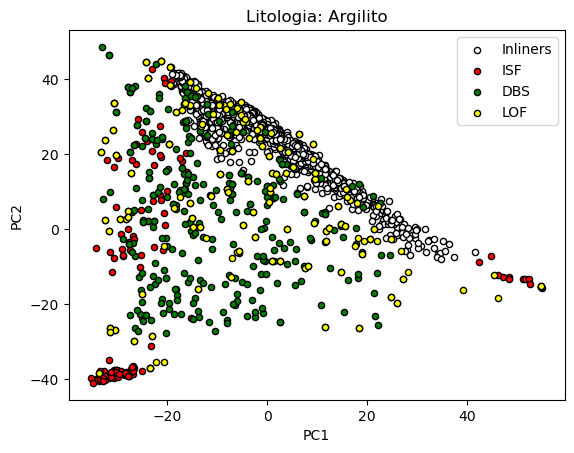

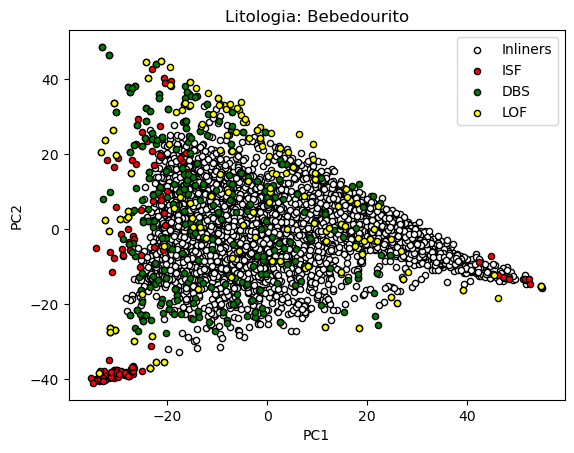

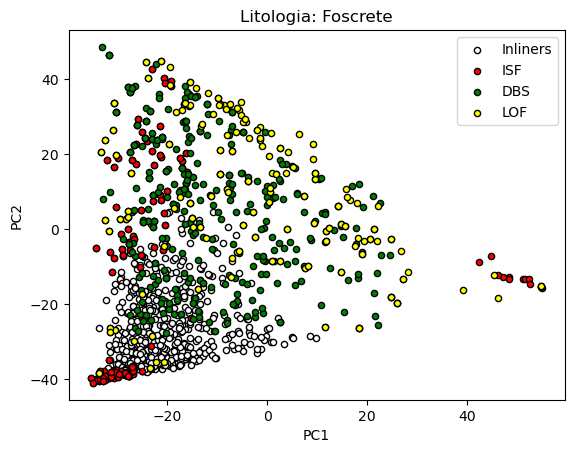

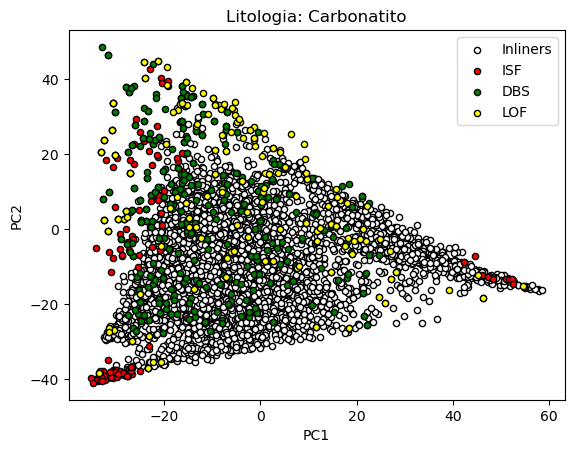

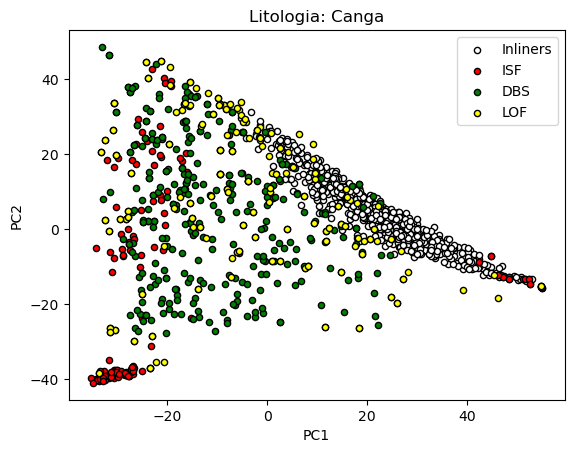

In [32]:
for litho in list(dh_pred.LITHO.unique()):
    plot.plot_model_pred_by_litho(dh_pred, litho)

- Nota-se que, de forma geral, as anomalias identificadas se situam em porções com menor densidade amostral no espaço das componentes principais. Isso era justamente o fenômeno esperado.
- Visualmente, os modelos LOF e DBS aparentam identificar outliers mais locais do que o modelo ISF que, por sua vez, tende a identificar anomalias globais.

A seguir será criada uma coluna `VOTES` contabilizando o número de votos de cada amostra recebeu para ser considerada uma anomalia. A situação em que `VOTES = 0` indica que nenhum dos três modelos rotulou um determinado exemplo como outlier (i.e. o exemplo é um inliner). A situação oposta, `VOTES = 3`, por outro lado, indica que todos os três modelos rotularam a observação como anomalia.

In [33]:
dh_pred['VOTES'] = dh_pred['ISF_PRED'] + dh_pred['DBS_PRED'] + dh_pred['LOF_PRED']
dh_pred.head()

,BHID,FROM,TO,LITHO,PC1,PC2,ISF_PRED,DBS_PRED,LOF_PRED,VOTES
0,DH-0001,3.40,5.00,Argilito,24.983979,1.637063,0,0,0,0
1,DH-0001,5.00,8.65,Argilito,23.236173,2.358010,0,0,0,0
2,DH-0001,8.65,12.00,Bebedourito,22.764923,2.640683,0,0,0,0
3,DH-0001,12.00,15.00,Bebedourito,24.580629,2.168093,0,0,0,0
4,DH-0001,15.00,18.00,Bebedourito,22.574931,4.138958,0,0,0,0


A figura abaixo mostra a disposição dos votos para outliers de cada uma das observações no espaço das duas primeiras componentes principais. Foi calculado um gráfico para cada uma das cinco litologias mais frequentes. As cores mais quentes indicam um maior número de votos:

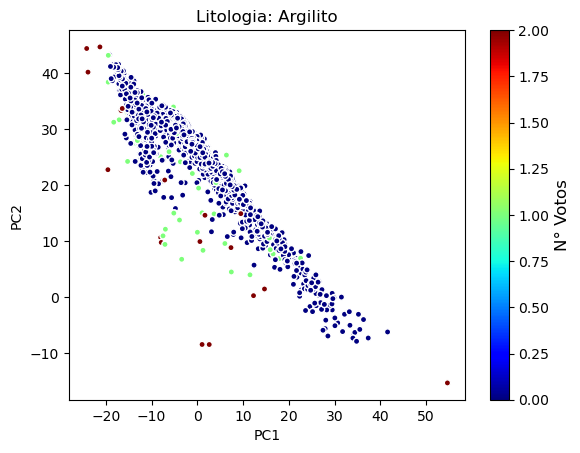

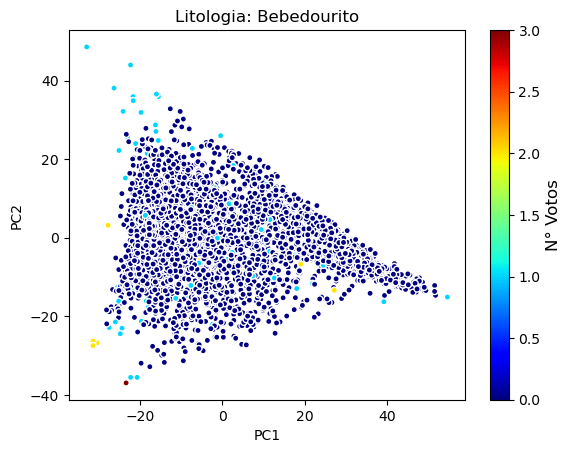

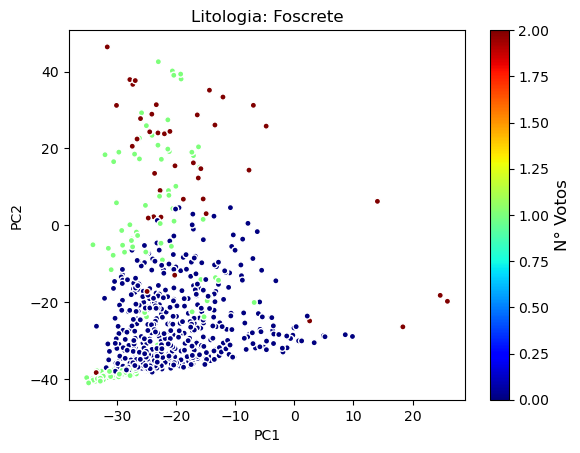

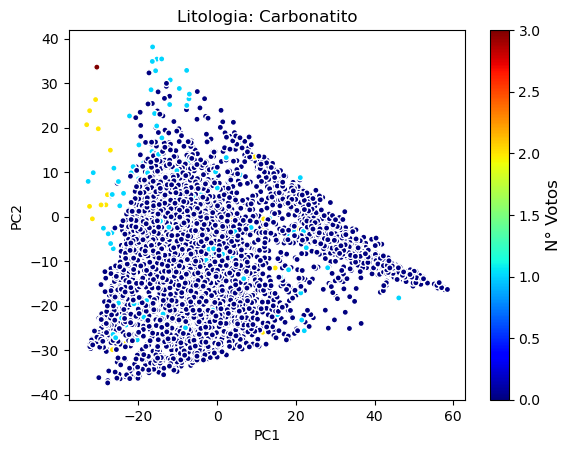

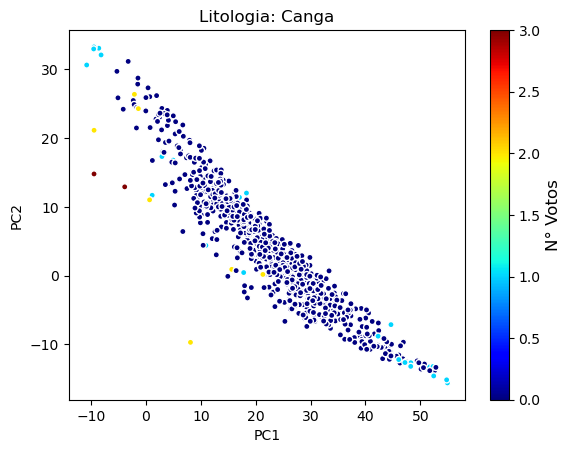

In [34]:
for litho in list(dh_pred.LITHO.unique()):
    plot.plot_model_votes_by_litho(dh_pred, litho)

- Nota-se que, em geral, apenas observações situadas em regiões de baixíssima densidade amostral (no espaço de atributos) mostram dois ou mais votos para serem rotuladas como anomalias.

### Validação por domain knowledge

Nesta sessão, as anomalias identificadas pelos modelos serão rotuladas. Nesse sentido, adotou-se a heurística de que apenas observações rotuladas como anomalias para dois ou mais modelos serão avaliadas. Ao todo foram identificados 110 intervalos anômalos:

In [35]:
df_anomaly = post.get_anomalies(dh, dh_pred, min_nb_votes=1)
df_anomaly

,BHID,FROM,TO,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITHO,ISF_PRED,DBS_PRED,LOF_PRED,VOTES
1171,DH-0039,51.00,54.00,33.30,45.10,12.34,0.51,0.33,0.15,Bebedourito,1,1,1,3
8218,DH-0261,15.00,18.25,16.73,3.03,6.26,19.10,24.60,0.32,Canga,1,1,1,3
10665,DH-0358,107.50,110.00,0.62,7.57,3.20,62.40,2.61,14.40,Carbonatito,1,1,1,3
6375,DH-0188,60.00,63.60,12.91,1.57,10.80,15.40,22.90,1.18,Canga,1,1,1,3
481,DH-0015,77.00,80.00,10.60,14.30,16.66,42.90,1.94,0.93,Foscrete,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,DH-0156,32.00,35.00,3.18,2.36,26.70,9.54,6.81,1.87,Bebedourito,0,1,1,2
5530,DH-0154,120.20,121.85,16.00,14.30,14.40,26.50,0.10,0.24,Carbonatito,0,1,1,2
4809,DH-0135,158.45,160.00,4.80,6.70,9.20,72.20,0.56,0.16,Foscrete,1,1,0,2
4780,DH-0135,63.00,64.65,14.00,14.30,33.70,9.78,6.75,0.14,Canga,0,1,1,2


- A amostra de índice `578` foi descrita como foscrete (`Foscrete`). Entretanto, essa amostra deveria ter sido descrita, provavelmente, como canga (`Canga`), dado seu elevado teor em `FE2O3`. Além disso, o foscrete, minério mais rico de fosfato da mina em questão, normalmente apresenta teores de `P2O5` superiores a 20%.
- A amostra de índice `8195` foi descrita como canga (`Canga`). Entretanto, essa foi incorretamente descrita, já que apresenta um teor de `FE2O3` de apenas 6%. Em geral, cangas apresentam teores de `FE2O3` superiores a 40%.
- A amostra de índice `10642` foi descrita como carbonatito (`Carbonatito`). Entretanto, como os carbonatitos são rochas tipicamente pobres em `SIO2` e ricas em `CAO` e `P2O5`, esse intervalo foi incorretamente descrito como `Carbonatito`.
- A amostra de índice `14441` foi descrita como foscrete (`Foscrete`). Entretanto, nota-se que, pelo teor baixíssimo em `P2O5`, essa rocha foi incorretamente descrita.
- A amostra de índice `8911` foi descrita como foscrete (`Foscrete`). Entretanto, essa amostra deveria ter sido descrita, provavelmente, como canga (`Canga`), dado seu elevado teor em `FE2O3`. Além disso, o teor baixo em `P2O5` também aponta para um possível erro de descrição.

### Validação por injeção de anomalias

Nesta sessão, algumas anomalias artificiais serão introduzidas para avaliar o desempenho do modelo Isolation Forest. Essas anomalias consistem um intervalos artificalmente gerados, onde se sabe que a descrição litológica está incorreta. Esse tipo de validação é comum em tarefas do tipo detecção de anomalias não-supervisionada, em que não existe uma variável resposta (i.e. target).

A seguinte convenção foi adotada:
- `0:` inliner (dado normal)
- `1:` outlier (dado anômalo)

In [36]:
injected_anomalies = io.read_csv('injected_anomalies.csv')
injected_anomalies

,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITHO
0,55.3,0.5,2.3,1.2,20.10,15.2,Bebedourito
1,40.5,2.2,1.2,5.6,23.50,18.5,Bebedourito
2,2.2,0.5,1.2,60.1,22.50,11.2,Carbonatito
3,0.5,1.2,2.3,65.2,20.20,9.2,Carbonatito
4,20.0,11.0,55.3,9.0,5.40,6.1,Argilito
5,17.5,13.3,2.5,60.0,3.20,5.9,Argilito
6,20.5,20.1,7.2,45.2,0.10,5.2,Canga
7,25.2,25.1,5.4,38.2,0.05,4.1,Canga
8,7.5,2.1,50.9,1.2,25.20,12.5,Foscrete
9,5.9,0.6,55.6,0.2,21.30,14.2,Foscrete


In [37]:
injected_anomalies['ISF_PRED'] = isf_pipeline.predict(injected_anomalies)
injected_anomalies['ISF_PRED'] = injected_anomalies['ISF_PRED'].apply(lambda x: 0 if x != -1 else 1)
injected_anomalies

,P2O5,CAO,FE2O3,SIO2,AL2O3,MGO,LITHO,ISF_PRED
0,55.3,0.5,2.3,1.2,20.10,15.2,Bebedourito,1
1,40.5,2.2,1.2,5.6,23.50,18.5,Bebedourito,1
2,2.2,0.5,1.2,60.1,22.50,11.2,Carbonatito,1
3,0.5,1.2,2.3,65.2,20.20,9.2,Carbonatito,1
4,20.0,11.0,55.3,9.0,5.40,6.1,Argilito,1
5,17.5,13.3,2.5,60.0,3.20,5.9,Argilito,1
6,20.5,20.1,7.2,45.2,0.10,5.2,Canga,1
7,25.2,25.1,5.4,38.2,0.05,4.1,Canga,1
8,7.5,2.1,50.9,1.2,25.20,12.5,Foscrete,1
9,5.9,0.6,55.6,0.2,21.30,14.2,Foscrete,1


- Dos 10 intervalos artificiais anômalos avaliados, o modelo ISF rotulou como 10 deles como anomalias. Isso corresponde a uma acurácia de 100%.

## Conclusão

As metodologias de detecção de anomalias não-supervisionada mostrou resultados promissores para identificação de possíveis erros de descrição litológica em testemunhos de sondagem, pois:
- A validação por _domain knowledge_ mostrou, para os cinco intervalos avaliados, que a metodologia aparentemente identificou corretamente descrições litológicas incorretas.
- A validação por injeção de anomalias artificais mostrou que 100% das anomalias artificiais avaliadas foram corretamente rotuladas como outliers.

Como o problema dos erros de descrição litológica não conta com exemplo rotulados de anomalia, as métricas clássicas de validação de modelo não podem ser utilizadas. Nesse sentido, torna-se ainda mais importante a existência de um profissional qualificado (com _domain knowledge_) para validar a performance do modelo.